# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip" ,'dog_dataset.zip')
urllib.request.urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip",'human_dataset.zip')
urllib.request.urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz",'DogVGG16Data.npz')

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing.image import *
from keras.models import Model
from keras.layers import *
import numpy as np
import numba
import urllib.request
from functools import lru_cache
import tensorflow as tf
from glob import glob
import pickle

## tf oom errors at high batch sizes ##
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
###

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


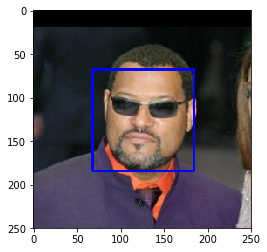

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def face_detector_box(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb
    

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def countpercent(data, func=face_detector, flip=False):
    div, results, misclassified = len(data), [] , []
    for x in data:
        if not flip:
            if func(x):
                results.append(x)
            else:
                misclassified.append(x)
        else:
            if func(x):
                misclassified.append(x)
            else:
                results.append(x)
    res_string = (len(results)*100/div) if not flip else ((div-len(results))*100/div)
    return res_string , misclassified

99.0% human faces detected
12.0% dog faces detected


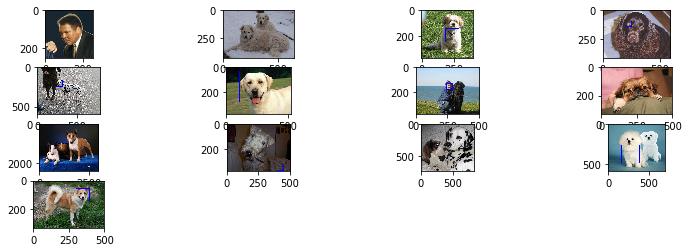

In [6]:
#classify and print out anomalies.

humans_correct, humans_misclassified = countpercent(human_files_short)
dogs_correct, dogs_misclassified = countpercent(dog_files_short, flip=True)


print("{}% human faces detected".format(humans_correct)) 
print("{}% dog faces detected".format(dogs_correct)) 

misclassified  = humans_misclassified + dogs_misclassified
numimgs = len(misclassified)

fig  = plt.figure(numimgs,(numimgs,4))
x = 1

for imgpth in misclassified:
    axes = fig.add_subplot(numimgs//3,4,x)
    img = cv2.imread(imgpth)
    axes.imshow(face_detector_box(img))
    x+=1

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

It is indeed a reasonable expectation to pose onto our users, we can workaround this problem by using data augmenting generative models trained on top of our deep learning networks, that could theoretically fill in the missing details and let the face detection work with lesser and/or lower quality data points.

I have implemented an algorithm, using the dlib library, it's implementation is very similar and runs a bit faster and seems to be more accurate against false positives. Also, the dlib library has a lot more functionality on offer, by thoughtfully using them, we can possibly rack up our accuracies even further. 

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
import dlib

#using dlib hog algorithm.
detector = dlib.get_frontal_face_detector()

def face_detector_dlib(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray,0)
    return len(faces) > 0

def face_detector_dlib_box(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray,0)
    for box in faces:
        (x,y,w,h) = box.left(), box.top(), box.right(), box.bottom()
        cv2.rectangle(img,(x,y),(w,h),(255,0,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

In [8]:
%timeit face_detector_dlib(dog_files_short[0])

34 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit face_detector(dog_files_short[0])

48.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


99.0% human faces detected
6.0% dog faces detected


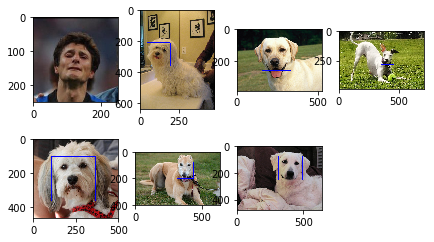

In [10]:
#classify and print out anomalies.

humans_correct, humans_misclassified = countpercent(human_files_short,
                                                func=face_detector_dlib)

dogs_correct, dogs_misclassified = countpercent(dog_files_short,
                                                func=face_detector_dlib,
                                                flip=True)


print("{}% human faces detected".format(humans_correct)) 
print("{}% dog faces detected".format(dogs_correct)) 

misclassified  = humans_misclassified + dogs_misclassified
numimgs = len(misclassified)

fig  = plt.figure(numimgs,(numimgs,4))
x = 1

for imgpth in misclassified:
    axes = fig.add_subplot(numimgs//3,4,x)
    img = cv2.imread(imgpth)
    axes.imshow(face_detector_dlib_box(img))
    x+=1

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [11]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [12]:
from keras.preprocessing import image
import numba
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and
    # return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        list_of_tensors.append(path_to_tensor(img_path))
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [13]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

1.0% human faces detected as dogs
100.0% dog faces detected as dogs


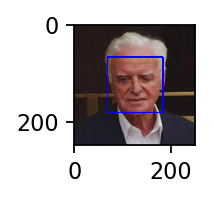

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# classify and print out anomalies.

humans_correct, humans_misclassified = countpercent(human_files_short, func=dog_detector, flip=True)
dogs_correct, dogs_misclassified = countpercent(dog_files_short, func=dog_detector)


print("{}% human faces detected as dogs".format(humans_correct)) 
print("{}% dog faces detected as dogs".format(dogs_correct)) 

misclassified  = humans_misclassified + dogs_misclassified
numimgs = len(misclassified)


fig  = plt.figure(1,(20,1), dpi=160)
x = 1

for imgpth in misclassified:
    axes = fig.add_subplot(1,1,x)
    img = cv2.imread(imgpth)
    axes.imshow(face_detector_box(img))
    x+=1

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
np.save('mydata/train_tensors_originals.npy',train_tensors)
np.save('mydata/valid_tensors_originals.npy',valid_tensors)
np.save('mydata/test_tensors_originals.npy',test_tensors)

In [16]:
#loading from disk for faster file run times.

train_tensors = np.load('mydata/train_tensors_originals.npy')
valid_tensors = np.load('mydata/valid_tensors_originals.npy')
test_tensors = np.load('mydata/test_tensors_originals.npy')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  

* I have used a slightly modified version of the hinted CNN architecture, as it could converge fast enough (accuracy > 1%) for the low number of epochs (<10) it's supposed to run for. 

* I tried using more complex architectures but the time to train and tune the models from scratch were prohibitive enough that I had to exclude it from the scope of this project.

* For the Chosen CNN architecture i have used 3 Conv2D layers with progressively increasing kernel sizes of 3,5 and 7 with Zero-Padding, so as to be able to extract "localized" (up,down,left,right) spatial information around every point in the preceding inputs.

* All 3 Conv2D layers are then fed into MaxPooling2D layers with kernel size 2, with the intention to capture more of the contrast and edge related information coming in from the conv2D layers. 

* The Top fully connected layer is made up of 2 separate Dense layers with 532 and 133 neurons each, and are connected together by a Dropout layer with a droput rate of 0.25.

In [128]:
from keras.layers import *
from keras.models import Sequential
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
### TODO: Define your architecture.

modelmini = Sequential()

#sparse/convolutional layers for features detection
modelmini.add(Conv2D(32, kernel_size=3, 
                     activation='relu',
                     padding='valid',
                     input_shape=(224,224,3), 
                     name = 'block1_conv_1_3_1_16'))

modelmini.add(MaxPooling2D(pool_size=2, padding='same',
                           name = 'block1_MAXpool_0_2_1'))

modelmini.add(Conv2D(64, kernel_size=5, 
                     activation='relu',
                     padding='valid', 
                     name = 'block2_conv_2_3_1_32'))

modelmini.add(MaxPooling2D(pool_size=2,
                           padding='same',
                           name = 'block2_MAXpool_0_2_1'))

modelmini.add(Conv2D(256, kernel_size=7,
                     activation='relu',
                     padding='valid', 
                     name = 'block3_conv_1_3_1_64'))

modelmini.add(MaxPooling2D(pool_size=2,
                           padding='same',
                           name = 'block3_MAXpool_0_2_1'))

#GAP layer
modelmini.add(GlobalMaxPooling2D())



#fully Connected Layers for classifcation.
modelmini.add(Dense(532, activation='relu', name = 'blockfc_dense0_532_softmax'))
modelmini.add(Dropout(0.25))
modelmini.add(Dense(133, activation='softmax', name = 'blockfc_denseF_133_softmax'))


#2 million parameters  --> 26.6746%% accuracy on epoch 50
modelmini.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv_1_3_1_16 (Conv2D (None, 222, 222, 32)      896       
_________________________________________________________________
block1_MAXpool_0_2_1 (MaxPoo (None, 111, 111, 32)      0         
_________________________________________________________________
block2_conv_2_3_1_32 (Conv2D (None, 107, 107, 64)      51264     
_________________________________________________________________
block2_MAXpool_0_2_1 (MaxPoo (None, 54, 54, 64)        0         
_________________________________________________________________
block3_conv_1_3_1_64 (Conv2D (None, 48, 48, 256)       803072    
_________________________________________________________________
block3_MAXpool_0_2_1 (MaxPoo (None, 24, 24, 256)       0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)               0         
__________

### Compile the Model

In [134]:
from keras.optimizers import SGD

optimizer = SGD(lr=1e-4,momentum=0.9,nesterov=False) #small learning rates

modelmini.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [135]:
from keras.callbacks import *

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 8

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/minimodel_weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

modelmini.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, 
          callbacks=[checkpointer,reduce_lr], verbose=0)



Epoch 00001: val_loss improved from inf to 3.38327, saving model to saved_models/minimodel_weights.best.from_scratch.hdf5

Epoch 00002: val_loss improved from 3.38327 to 3.37821, saving model to saved_models/minimodel_weights.best.from_scratch.hdf5

Epoch 00003: val_loss did not improve from 3.37821

Epoch 00004: val_loss did not improve from 3.37821

Epoch 00005: val_loss did not improve from 3.37821

Epoch 00006: val_loss did not improve from 3.37821

Epoch 00007: val_loss did not improve from 3.37821

Epoch 00008: val_loss did not improve from 3.37821


### Load the Model with the Best Validation Loss

In [136]:
modelmini.load_weights('saved_models/best_minimodel_weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [137]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(modelmini.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

#Test accuracy: 26.6746%

Test accuracy: 26.6746%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [141]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [146]:
from keras.layers import *
from keras.models import Sequential
import keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

VGG16_model = Sequential()

# using FC architecture from VGG 16 Model - 'D'
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(4096, activation='relu'))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(4096, activation='relu'))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               544901    
Total para

### Compile the Model

In [152]:
from keras.optimizers import *

optimizer = SGD(lr=0.9e-4, momentum = 0.9, nesterov=True)

VGG16_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Train the Model

In [153]:
from keras.callbacks import *

epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                              patience=5, min_lr=0, mode='min' ,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                             patience=10, verbose=1, mode='auto')
history = History()

vgg16_callbacks = [checkpointer, earlystopper, reduce_lr, history]

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=epochs, batch_size=20, callbacks = vgg16_callbacks, verbose=0)


Epoch 00001: val_loss improved from inf to 0.74834, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00002: val_loss did not improve from 0.74834

Epoch 00003: val_loss did not improve from 0.74834

Epoch 00004: val_loss did not improve from 0.74834

Epoch 00005: val_loss did not improve from 0.74834

Epoch 00006: val_loss did not improve from 0.74834

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000136438758e-06.

Epoch 00007: val_loss did not improve from 0.74834

Epoch 00008: val_loss did not improve from 0.74834

Epoch 00009: val_loss did not improve from 0.74834

Epoch 00010: val_loss did not improve from 0.74834

Epoch 00011: val_loss did not improve from 0.74834

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.000000318337698e-07.
Epoch 00011: early stopping


### Load the Model with the Best Validation Loss

In [154]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [155]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

session.close()

Test accuracy: 80.0239%


### Predict Dog Breed with the Model

In [156]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [18]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
# importing resnet50 bottleneck features.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50 = bottleneck_features['test']

In [19]:
from keras.applications.resnet50 import ResNet50, preprocess_input
import pandas as pd

Convert_to = ResNet50(weights='imagenet',
                      input_shape=(224,224,3), include_top=False)

In [20]:
# extract module has long load times, so using this one.
def Extract_Resnet50(imagepath):
    image = path_to_tensor(imagepath)
    return Convert_to.predict(preprocess_input(image))

In [21]:
# modifying the extract module to accept our precomputed image tensors
imgen = ImageDataGenerator(preprocessing_function=preprocess_input)
def extract2bneck(tensor, augfn=imgen):
    tensor = np.expand_dims(tensor*255, axis=0)
    bneck = Convert_to.predict_generator(imgen.flow(tensor), 1)
    return bneck.reshape(1,1,2048)

original_bneck       11.725855
nb_extract_bneck     11.725856
keras_nbextractfn    11.725856
dtype: float32 

 original_bneck       0.878223
nb_extract_bneck     0.878223
keras_nbextractfn    0.878223
dtype: float32 

 original_bneck       0.0
nb_extract_bneck     0.0
keras_nbextractfn    0.0
dtype: float32


,original_bneck,nb_extract_bneck,keras_nbextractfn
original_bneck,1.0,1.0,1.0
nb_extract_bneck,1.0,1.0,1.0
keras_nbextractfn,1.0,1.0,1.0


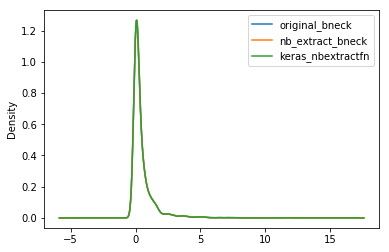

In [22]:
# comparing our bottleneck features with the udacity features
# to allow for augmentation.
from sklearn import preprocessing

aug_train = np.vstack([train_resnet50[0].flatten(),
                       Extract_Resnet50(train_files[0]).flatten(),
                       extract2bneck(train_tensors[0]).flatten()]).T

x = pd.DataFrame(aug_train, columns=['original_bneck','nb_extract_bneck', 
                                     'keras_nbextractfn'])

print(x.max(),'\n\n', x.std(),'\n\n', x.min())
x.plot.density()
x.corr()

#### Bottleneck Features match with Udacity Given Features, so we can now move on with augmentation

In [23]:
#defining augmenting functions, using Keras Preprocessing Module.

auggen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.15,
                              height_shift_range=0.15,
                              shear_range=0.15,
                              zoom_range=0.15,
                              horizontal_flip=True,
                              fill_mode='nearest',
                            preprocessing_function=preprocess_input)

noauggen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
from functools import partial
from multiprocessing.dummy import Pool as ThreadPool

pool = ThreadPool(16) #thread utilization is very low with sequential processing.

In [ ]:
aug_train_resnet50 = np.array(list(pool.map(partial(extract2bneck, augfn=auggen), train_tensors)))
np.save('mydata/aug_1x_train_resnet50.npy', aug_train_resnet50)

In [32]:
aug_valid_resnet50 = np.array(list(pool.map(partial(extract2bneck, augfn=auggen), valid_tensors)))
np.save('mydata/aug_1x_valid_resnet50.npy', aug_valid_resnet50)

In [ ]:
aug_test_resnet50 = np.array(list(pool.map(partial(extract2bneck, augfn=noauggen), test_tensors)))
np.save('mydata/aug_1x_test_resnet50.npy', aug_test_resnet50)

In [33]:
# for loading 1x augmented sets

aug_train_resnet50 = np.load('mydata/aug_1x_train_resnet50.npy')
aug_valid_resnet50 = np.load('mydata/aug_1x_valid_resnet50.npy')
aug_test_resnet50 = np.load('mydata/aug_1x_test_resnet50.npy')

In [34]:
aug2x_training_set = np.concatenate([train_resnet50, aug_train_resnet50], axis=0)
aug2x_training_target_set = np.concatenate([train_targets, train_targets], axis=0)
np.save('mydata/2x_aug_train_resnet50.npy', aug2x_training_set)
np.save('mydata/2x_aug_train_resnet50_targets.npy', aug2x_training_target_set)

aug2x_validation_set = np.concatenate([valid_resnet50, aug_valid_resnet50], axis=0)
aug2x_validation_target_set = np.concatenate([valid_targets, valid_targets], axis=0)
np.save('mydata/2x_aug_validation_resnet50.npy', aug2x_validation_set)
np.save('mydata/2x_aug_validation_resnet50_targets.npy', aug2x_validation_target_set)

In [38]:
# for loading 2x augmented sets

aug_2x_train_resnet50 = np.load('mydata/2x_aug_train_resnet50.npy')
aug2x_training_target_set = np.load('mydata/2x_aug_train_resnet50_targets.npy')

aug_2x_valid_resnet50 = np.load('mydata/2x_aug_validation_resnet50.npy')
aug2x_validation_target_set = np.load('mydata/2x_aug_validation_resnet50_targets.npy')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

* The CNN architecture is loaded up from the resnet50 module in Keras applications, without the top layers, and with imagenet weights.

* The model is a dense connected layer, and is to be trained on precomputed bottleneck features. The dense layer itself has 133 neurons and softmax activations.

* The model was trained on 2x augmented bottleneck features with a SGD optimizer with nesterov momentum.

* The **2x** augmented features are generated by merging the computed features from a custom implemenation of Keras ImageDataGenerator Module and ExtractResnet50 Function **(1x)** and the Udacity Pretrained Features set **(1x)**.

* The training was carried out with very low learning rates (~1e-4), and was made to last for a total of 1000 maximum epochs, with callbacks for learning rate adjustments and early stopping.

* Since the original architecture was prone to severe overfitting, a dropout layer was added to reduce the model's tendency to memoize training patterns.

In [64]:
### TODO: Define your architecture.
from keras.models import Model
from keras.layers import *
from keras.models import Sequential

# import keras.backend as K
# from keras.layers.normalization import BatchNormalization
# from keras.regularizers import l2

resnet50fc_model = Sequential()
resnet50fc_model.add(GlobalAveragePooling2D(input_shape=(aug_train_resnet50.shape[1:])))
resnet50fc_model.add(Dropout(0.35))
resnet50fc_model.add(Dense(133, activation='softmax' ))
resnet50fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [65]:
from keras.optimizers import *
### TODO: Compile the model.

optimizer = sgd(lr=0.9e-4, momentum=0.9, nesterov=True)

resnet50fc_model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                          metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [66]:
from keras.callbacks import *
### TODO: Train the model.

epochs = 1000

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                              patience=10, min_lr=0, mode='min' ,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                             patience=30, verbose=1, mode='auto')
history = History()

resnet50_callbacks = [checkpointer, earlystopper, reduce_lr, history]

resnet50fc_model.fit(aug_2x_train_resnet50, aug2x_training_target_set,
          validation_data=(aug_2x_valid_resnet50, aug2x_validation_target_set),
          epochs=epochs, batch_size=64, callbacks=resnet50_callbacks, 
          verbose=0, shuffle=True)


Epoch 00001: val_loss improved from inf to 4.89042, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00002: val_loss improved from 4.89042 to 4.44566, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00003: val_loss improved from 4.44566 to 4.07316, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00004: val_loss improved from 4.07316 to 3.74563, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00005: val_loss improved from 3.74563 to 3.45495, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00006: val_loss improved from 3.45495 to 3.19688, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00007: val_loss improved from 3.19688 to 2.96902, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00008: val_loss improved from 2.96902 to 2.76680, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00009: val_loss improved from 2.76680 to 2.58889, saving model to saved_models/weights.best.r

Epoch 00145: val_loss improved from 0.62018 to 0.61893, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00146: val_loss improved from 0.61893 to 0.61786, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00147: val_loss improved from 0.61786 to 0.61717, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00148: val_loss improved from 0.61717 to 0.61601, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00149: val_loss improved from 0.61601 to 0.61450, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00150: val_loss improved from 0.61450 to 0.61341, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00151: val_loss improved from 0.61341 to 0.61256, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00152: val_loss improved from 0.61256 to 0.61207, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00153: val_loss improved from 0.61207 to 0.61117, saving model to saved_models/weights.bes

Epoch 00298: val_loss did not improve from 0.54121

Epoch 00299: val_loss improved from 0.54121 to 0.54073, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00300: val_loss improved from 0.54073 to 0.54029, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00301: val_loss improved from 0.54029 to 0.54003, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00302: val_loss improved from 0.54003 to 0.54001, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00303: val_loss did not improve from 0.54001

Epoch 00304: val_loss improved from 0.54001 to 0.53979, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00305: val_loss improved from 0.53979 to 0.53972, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00306: val_loss improved from 0.53972 to 0.53964, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00307: val_loss improved from 0.53964 to 0.53943, saving model to saved_models/weights.best.resnet5

Epoch 00482: val_loss improved from 0.51423 to 0.51412, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00483: val_loss improved from 0.51412 to 0.51401, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00484: val_loss improved from 0.51401 to 0.51395, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00485: val_loss did not improve from 0.51395

Epoch 00486: val_loss improved from 0.51395 to 0.51384, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00487: val_loss did not improve from 0.51384

Epoch 00488: val_loss did not improve from 0.51384

Epoch 00489: val_loss improved from 0.51384 to 0.51384, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 00490: val_loss did not improve from 0.51384

Epoch 00491: val_loss did not improve from 0.51384

Epoch 00492: val_loss did not improve from 0.51384

Epoch 00493: val_loss improved from 0.51384 to 0.51373, saving model to saved_models/weights.best.resnet50.hdf5

Epoch 0049

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


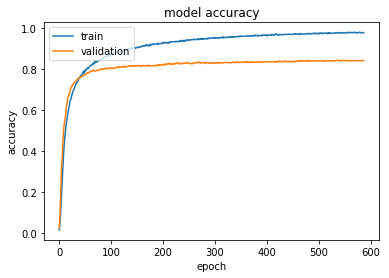

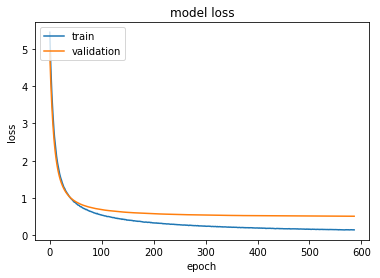

In [70]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [71]:
### TODO: Load the model weights with the best validation loss.
resnet50fc_model.load_weights('saved_models/weights.best.resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [73]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set

resnet50fc_model_predictions = [np.argmax(resnet50fc_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet50fc_model_predictions)==np.argmax(test_targets,axis=1))/len(resnet50fc_model_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

session.close()

#best: 85.4067%

Test accuracy: 85.1675%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [88]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = Extract_Resnet50(img_path)
    # obtain predicted vector
    predicted_vector = resnet50fc_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [114]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_detector_class(img_path, force=False):
    if resnet50_predict_breed(img_path) is None:
        return None
    else:
        return resnet50_predict_breed(img_path)

def algo_detect(imagepath):
    answer = dog_detector_class(imagepath)
    image = path_to_tensor(imagepath).reshape(224,224,3)/255
    hasface = face_detector_dlib(imagepath) and face_detector(imagepath)
    if hasface:
        print('Hello, human!')
    else:
        print('Woof!, Woof!')
    print('You look like a ....\n')
    plt.imshow(image)
    print(answer)
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is as per my expectations, the model behaves well enough when the images are 'normal', but throws errors when the images are not accurately depicting dog classes. i.e when they have more than one class in the same image, or when there are no recognizable(i.e. dogs) classes.

* Things to improve upon:
    * Actual 'None' Class Detection
    * Multiple Objects Classification
        * Implement a multi-class object detection and localisation model like yolo, that can diffrentiate between multiple categories in the same image.
    * Going beyond 85% accuracy



In [115]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

Hello, human!
You look like a ....

Clumber_spaniel


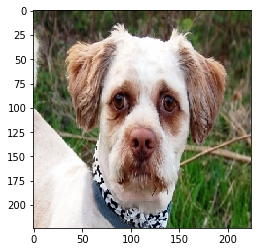

In [116]:
algo_detect('mydata/test/buscemi_doggo.jpg')

Woof!, Woof!
You look like a ....

Dachshund


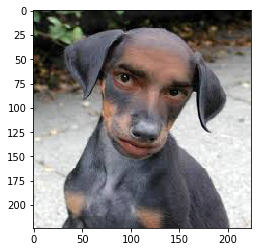

In [117]:
algo_detect('mydata/test/personlike_doggo.jpg')

Woof!, Woof!
You look like a ....

Chihuahua


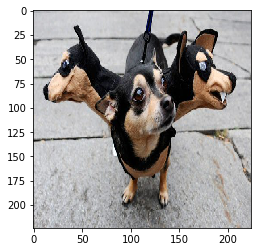

In [118]:
algo_detect('mydata/test/3x_doggo.jpg')

Woof!, Woof!
You look like a ....

Anatolian_shepherd_dog


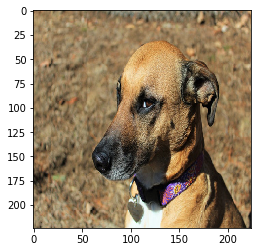

In [119]:
algo_detect('mydata/test/cautious_doggo.jpeg')

Hello, human!
You look like a ....

Silky_terrier


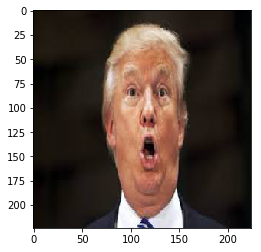

In [120]:
algo_detect('mydata/test/grump.jpg')

Hello, human!
You look like a ....

American_staffordshire_terrier


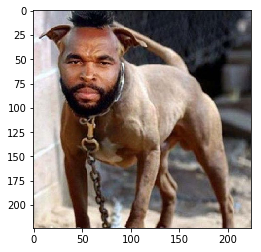

In [121]:
algo_detect('mydata/test/t_dawg.jpg')

Woof!, Woof!
You look like a ....

Affenpinscher


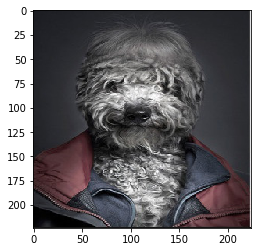

In [124]:
algo_detect('mydata/test/personlike_doggo_2.jpg')

Hello, human!
You look like a ....

Dachshund


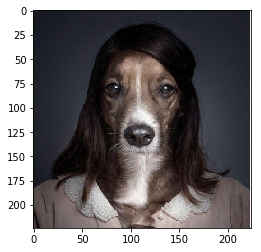

In [125]:
algo_detect('mydata/test/personlike_doggo_3.jpg')

Hello, human!
You look like a ....

French_bulldog


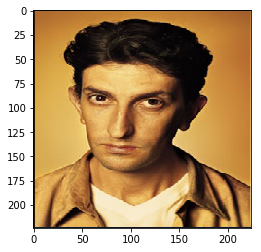

In [126]:
algo_detect('mydata/test/human.jpg')

Hello, human!
You look like a ....

Poodle


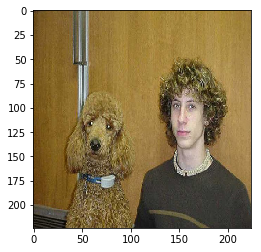

In [127]:
algo_detect('mydata/test/wheres_doggo.jpg')